In [2]:
import ast
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool
def calculator(query: str) -> str:
    """
    Dates are not supported.
    A simple calculator tool that evaluates mathematical expressions.
    The format of the input is a mathematical expression as a string. Dates not supported.
    Always use this tool for math calculations.
    """
    # evaluate safely and convert to str so tool returns a serializable value
    try:
        return str(eval(query))
    except Exception as e:
        return f"Error: {e}"


search = DuckDuckGoSearchRun()

tools = [search, calculator]

In [27]:
from langchain_ollama import ChatOllama

model = ChatOllama(
    model="gpt-oss:120b-cloud",
    temperature=0.1,
).bind_tools(tools)

In [28]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages" : res}

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

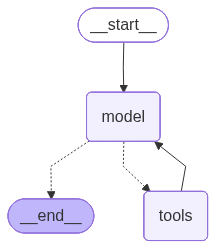

In [29]:
from IPython.display import Image

png = graph.get_graph().draw_mermaid_png()

Image(png)


In [31]:
from langchain_core.messages import HumanMessage

input_message = {"messages": [
    HumanMessage(content="""
    Sum the ages of all US presidents up to 2020.
                 """),
]}

calls = []

for c in graph.stream(input_message):
    calls.append(c)

In [32]:
calls

[{'model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:120b-cloud', 'created_at': '2025-11-12T16:45:31.867617679Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1281699131, 'load_duration': None, 'prompt_eval_count': 199, 'prompt_eval_duration': None, 'eval_count': 147, 'eval_duration': None, 'model_name': 'gpt-oss:120b-cloud', 'model_provider': 'ollama'}, id='lc_run--e689cefd-4e1d-4262-9ceb-6f0f015e3ea9-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'list of US presidents ages as of 2020 sum'}, 'id': 'e3eabbd2-ad38-4f51-b0fa-9117e3ba884d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 199, 'output_tokens': 147, 'total_tokens': 346})}},
 {'tools': {'messages': [ToolMessage(content="List of presidents of the United StatesThe White House, official residence of the president of the United States The president of the United States is the head of state and head of government of the United States, [1] indir

# Force tool calling

In [65]:
from typing import TypedDict, Annotated
from langchain_core.messages import AIMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import ToolCall
from uuid import uuid4

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages" : res}

def first_model(state: State) -> State:
    query = state["messages"][-1].content
    search_tool_call = ToolCall(
        name="duckduckgo_search", args={"query": query}, id=uuid4().hex
    )
    return {
        "messages" : AIMessage(content="", tool_calls=[search_tool_call])
    }

builder = StateGraph(State)
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

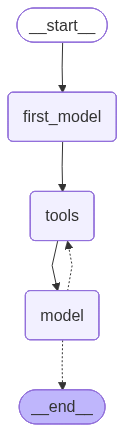

In [66]:
from IPython.display import Image

png = graph.get_graph().draw_mermaid_png()

Image(png)


In [67]:
calls

[{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='bf777aff-de9e-44f2-8431-76e4b133d553', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '\n    How old was the 30th president of the United States when he died?\n                 '}, 'id': '1b965e69f9684410b98118d15ff156ec', 'type': 'tool_call'}])}},
 {'tools': {'messages': [ToolMessage(content="Calvin Coolidge (born John Calvin Coolidge Jr.; [1] / ˈkuːlɪdʒ / KOOL-ij; July 4, 1872 – January 5, 1933) was the 30th president of the United States , serving from 1923 to 1929. John F. Kennedy died at the youngest age - 46 years old . James K. Polk is the youngest president to die of natural causes at 53 years old . * indicates the president is still alive. Those presidents' ages were calculated on January 20, 2025. Age of the Presidents of the United States when they died . Calvin Coolidge was the 30th president of the United States (1923–29). He acceded to the presidency after the 

In [68]:
from langchain_core.messages import HumanMessage

input_message = {"messages": [
    HumanMessage(content="""
    How old was the 30th president of the United States when he died?
                 """),
]}

calls = []

for c in graph.stream(input_message):
    calls.append(c)

In [69]:
calls

[{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='df747fb3-7856-4f2f-b13e-bd062162e54b', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '\n    How old was the 30th president of the United States when he died?\n                 '}, 'id': '265dae809f264d44876a98aaa61ec0d3', 'type': 'tool_call'}])}},
 {'tools': {'messages': [ToolMessage(content='Calvin Coolidge (born John Calvin Coolidge Jr.; [1] / ˈkuːlɪdʒ / KOOL-ij; July 4, 1872 - January 5, 1933) was the 30th president of the United States , serving from 1923 to 1929. A Republican lawyer from Massachusetts, he previously served as the 29th vice president from 1921 to 1923, under President Warren G. Harding, and as the 48th governor of Massachusetts from 1919 to 1921. Coolidge ... To date, eight U.S. presidents have died while serving in office; four of natural causes and four killed in acts of political violence. Calvin Coolidge was the 30th president of the United States ,

# Tool selection via RAG

In [10]:
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import ToolCall
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_ollama import ChatOllama

model = ChatOllama(
    model="gpt-oss:120b-cloud",
    temperature=0.1,
)

embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
)

tools_retriever = InMemoryVectorStore.from_documents(
    [Document(tool.description, metadata={"name": tool.name}) for tool in tools],
    embedding=embeddings
).as_retriever()

In [11]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state: State) -> State:
    selected_tools = [
        tool for tool in tools if tool.name in state["selected_tools"]
    ]
    res = model.bind_tools(selected_tools).invoke(state["messages"])
    return {"messages" : res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs = tools_retriever.invoke(query)
    return {
        "selected_tools": [doc.metadata["name"] for doc in tool_docs]
    }

builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

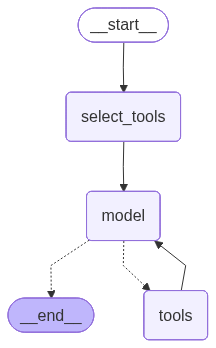

In [12]:
from IPython.display import Image

png = graph.get_graph().draw_mermaid_png()

Image(png)

In [13]:
from langchain_core.messages import HumanMessage

input_message = {"messages": [
    HumanMessage(content="""
    How old was the 30th president of the United States when he died?
                 """),
]}

calls = []

for c in graph.stream(input_message):
    calls.append(c)

In [14]:
calls

[{'select_tools': {'selected_tools': ['calculator', 'duckduckgo_search']}},
 {'model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:120b-cloud', 'created_at': '2025-11-12T20:32:47.77553181Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2312776991, 'load_duration': None, 'prompt_eval_count': 224, 'prompt_eval_duration': None, 'eval_count': 273, 'eval_duration': None, 'model_name': 'gpt-oss:120b-cloud', 'model_provider': 'ollama'}, id='lc_run--b4a0a7c1-4c45-4f5f-b376-e7b044404464-0', tool_calls=[{'name': 'calculator', 'args': {'query': '(1933-01-05) - (1872-07-04)'}, 'id': '7a39df54-e057-44ec-9f63-edad6e349094', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 273, 'total_tokens': 497})}},
 {'tools': {'messages': [ToolMessage(content='Error: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1)', name='calculator', id='39a49ac2-c0c8-46f5-95